In [4]:
import pandas as pd
import os

def load_usage_age_distribution(year):
    path = f"..//results//dataAnalysis//{year}//age_distribution.csv"
    if not os.path.exists(path):
        print(f"⚠️ Usage age distribution missing for {year}")
        return None
    df = pd.read_csv(path)
    df['year'] = int(year)
    return df.rename(columns={'count': 'usage_count', df.columns[0]: 'age'})

def load_crash_age_distribution(year):
    crash_file = f"..//results//matched_trips//matched_trips_{year}.csv"
    if not os.path.exists(crash_file):
        print(f"⚠️ Crash data missing for {year}")
        return None

    crashes = pd.read_csv(crash_file)
    # Calculate age from birth year if available and valid
    if 'birth year' in crashes.columns:
        current_year = int(year)
        crashes['birth year'] = pd.to_numeric(crashes['birth year'], errors='coerce')
        crashes['age'] = current_year - crashes['birth year']
        crashes = crashes[(crashes['age'] >= 1) & (crashes['age'] <= 100)]  # sanity filter
        age_dist = crashes.groupby('age').size().reset_index(name='crash_count')
        age_dist['year'] = current_year
        return age_dist
    else:
        print(f"⚠️ No birth year data in crashes for {year}")
        return None

def analyze_age_distribution_all_years():
    base_dir = "..//results//dataAnalysis"
    years = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()]
    years.sort()

    usage_all = []
    crash_all = []

    for year in years:
        print(f"\n📅 Processing crash age distribution for year: {year}")

        usage_df = load_usage_age_distribution(year)
        if usage_df is not None:
            usage_all.append(usage_df)

        crash_df = load_crash_age_distribution(year)
        if crash_df is not None:
            crash_all.append(crash_df)

    if not usage_all:
        print("❌ No usage age distribution data found.")
        return
    if not crash_all:
        print("❌ No crash age distribution data found.")
        return

    # Combine all years' usage age distribution
    usage_all_df = pd.concat(usage_all, ignore_index=True)
    # Sum counts across years by age (or keep separate by year if preferred)
    usage_summary = usage_all_df.groupby('age')['usage_count'].sum().reset_index()

    # Combine all years' crash age distribution
    crash_all_df = pd.concat(crash_all, ignore_index=True)
    crash_summary = crash_all_df.groupby('age')['crash_count'].sum().reset_index()

    # Merge usage and crash on age
    combined = pd.merge(usage_summary, crash_summary, on='age', how='outer').fillna(0)

    # Calculate percentage crash relative to usage per age
    combined['percentage'] = (combined['crash_count'] / combined['usage_count'].replace(0, pd.NA)) * 100
    combined['percentage'] = combined['percentage'].fillna(0)

    combined = combined.sort_values('age').reset_index(drop=True)
    
    output_path = os.path.join(base_dir, "extra_analysis", "all_years_crash_usage_age_distribution.csv")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    #output_path = os.path.join(base_dir, "all_years_crash_usage_age_distribution.csv")
    combined.to_csv(output_path, index=False)

    print(f"\n✅ Combined age distribution saved: {output_path}")
    print(combined.head(20))  # Print sample

# Run the analysis
analyze_age_distribution_all_years()



📅 Processing crash age distribution for year: 2013

📅 Processing crash age distribution for year: 2014

📅 Processing crash age distribution for year: 2015

📅 Processing crash age distribution for year: 2016

📅 Processing crash age distribution for year: 2017

📅 Processing crash age distribution for year: 2018

📅 Processing crash age distribution for year: 2019

📅 Processing crash age distribution for year: 2020

📅 Processing crash age distribution for year: 2021

📅 Processing crash age distribution for year: 2022
⚠️ Usage age distribution missing for 2022
⚠️ No birth year data in crashes for 2022

📅 Processing crash age distribution for year: 2023
⚠️ Usage age distribution missing for 2023
⚠️ No birth year data in crashes for 2023

📅 Processing crash age distribution for year: 2024
⚠️ Usage age distribution missing for 2024
⚠️ No birth year data in crashes for 2024

📅 Processing crash age distribution for year: 2025
⚠️ Usage age distribution missing for 2025
⚠️ No birth year data in c

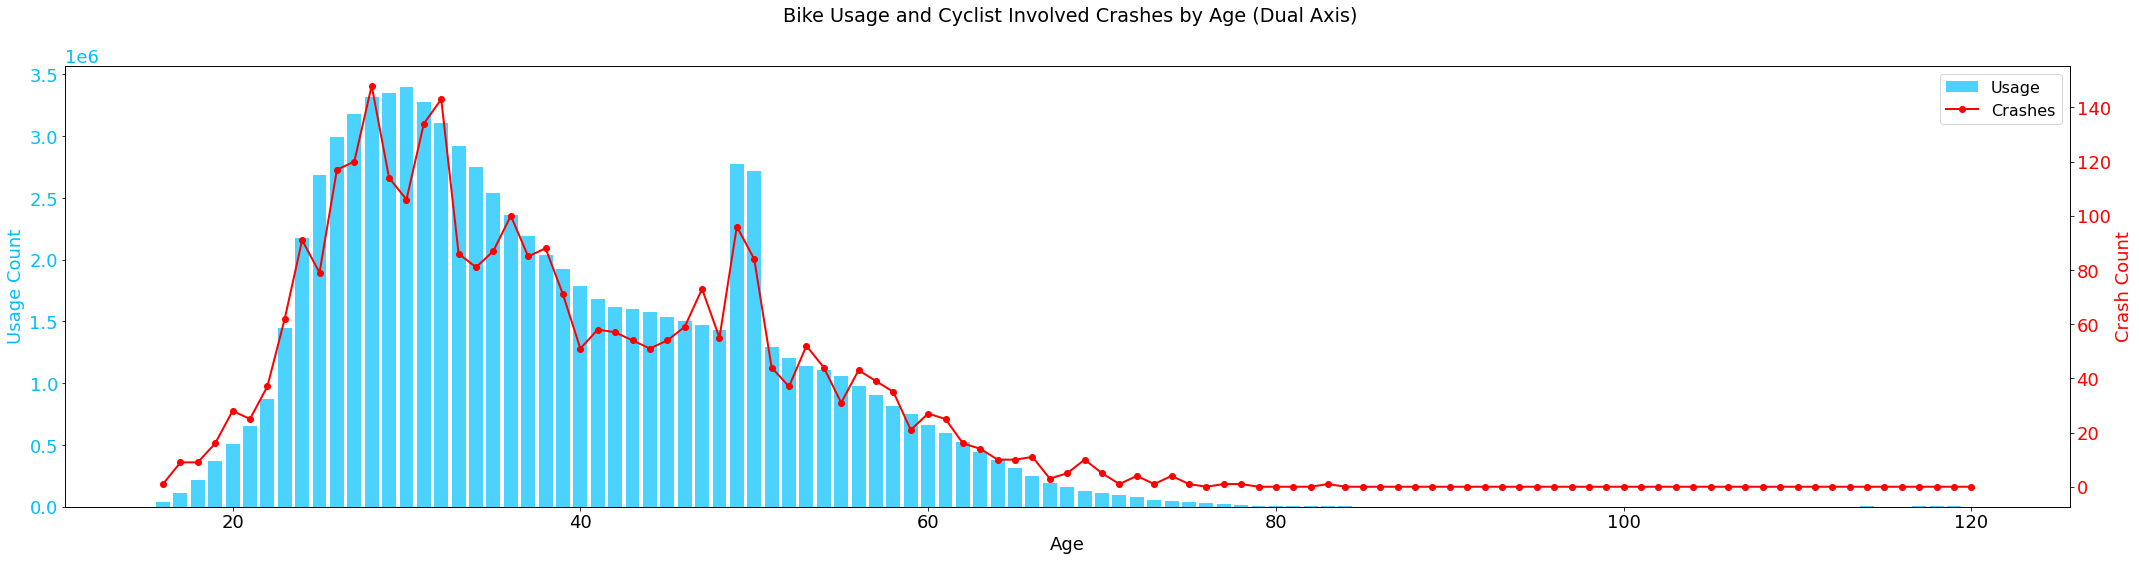

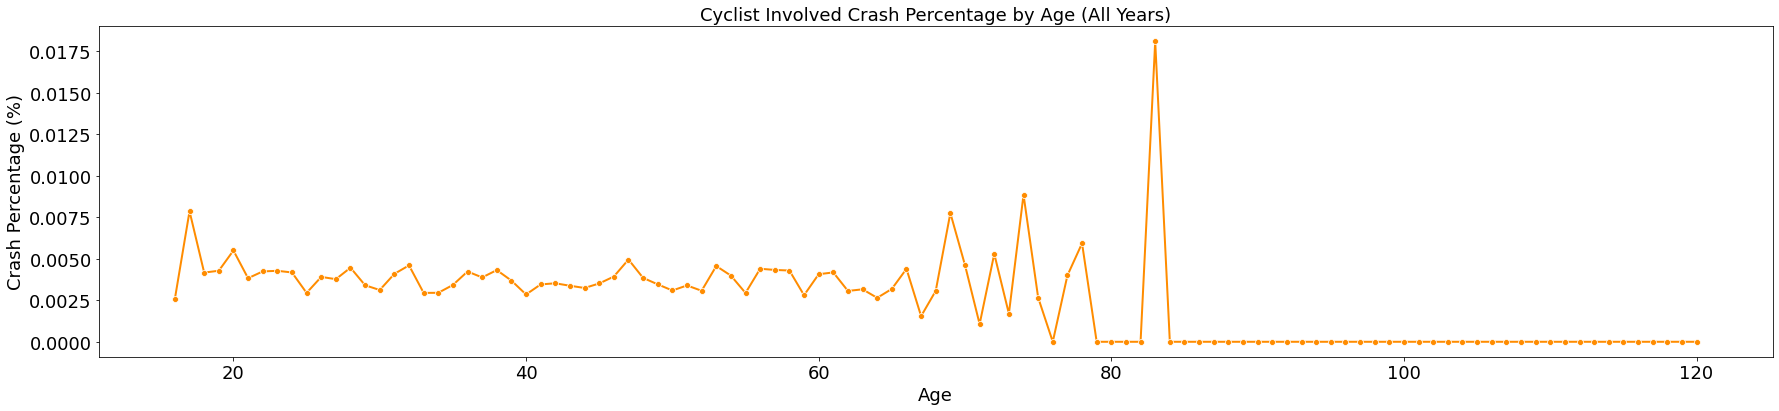

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
file_path = "..//results//dataAnalysis//extra_analysis//all_years_crash_usage_age_distribution.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()  # Clean column names
df_plot = df.copy()

# Create output dir
plot_dir = "..//results//dataAnalysis//extra_analysis"
os.makedirs(plot_dir, exist_ok=True)

# Set global font styles
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'figure.figsize': (25, 6)
})

# === Plot 1: Dual Y-Axis: Usage vs Crashes ===
#plt.figure(figsize=(30, 8))

fig1, ax1 = plt.subplots(figsize=(30, 8))
color1 = "deepskyblue"
color2 = "red"

# Bar for usage
ax1.bar(df_plot["age"], df_plot["usage_count"], color=color1, label="Usage", alpha=0.7)
ax1.set_xlabel("Age")
ax1.set_ylabel("Usage Count", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Line for crashes
ax2 = ax1.twinx()
ax2.plot(df_plot["age"], df_plot["crash_count"], color=color2, marker="o", linewidth=2, label="Crashes")
ax2.set_ylabel("Crash Count", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and legend
fig1.suptitle("Bike Usage and Cyclist Involved Crashes by Age (Dual Axis)")
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
ax1.legend(lines_labels, labels, loc='upper right')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "dual_axis_usage_crashes_by_age.png"), dpi=300)
plt.show()

# === Plot 2: Crash Percentage by Age ===
fig2, ax3 = plt.subplots()

sns.lineplot(x="age", y="percentage", data=df_plot, marker='o', color='darkorange', linewidth=2)
ax3.set_title("Cyclist Involved Crash Percentage by Age (All Years)")
ax3.set_xlabel("Age")
ax3.set_ylabel("Crash Percentage (%)")
#plt.xticks(rotation=45)
plt.tight_layout()

# Save
plt.savefig(os.path.join(plot_dir, "crash_percentage_by_age.png"), dpi=300)
plt.show()
